# Dependencies
For downloading dataset from kaggle

In [0]:
from google.colab import files

!pip install -q kaggle 

In [2]:
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


# Dataset preprocessing

In [1]:
! kaggle datasets download -d koryakinp/fingers

fingers.zip: Skipping, found more recently modified local copy (use --force to force download)


KeyboardInterrupt: ignored

In [0]:
!unzip -q fingers.zip -d .

In [2]:
import os

basedir_train = '/content/train'
basedir_test = '/content/test'

i = 0
for fname in os.listdir(basedir_test):
  if '5R' in fname or '5L' in fname:
    i += 1
print(i)

600


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

def form_data(basedir, size, split_ratio=0.8):
  i = 0
  x = np.empty((size, 150, 150, 3))
  y = np.empty(size)

  for fname in os.listdir(basedir):
    if(i >= size):
      break

    image = cv.imread(os.path.join(basedir, fname))
    image = cv.resize(image, (150, 150))
    z = -1

    if '5R' in fname or '5L' in fname:
      z = 5
    elif '4R' in fname or '4L' in fname:
      z = 4
    elif '3R' in fname or '3L' in fname:
      z = 3
    elif '2R' in fname or '2L' in fname:
      z = 2
    elif '1R' in fname or '1L' in fname:
      z = 1
    elif '0R' in fname or '0L' in fname:
      z = 0

    x[i] = image
    y[i] = z
    i += 1

  cut = int(size*split_ratio)
  x1 = x[:cut]
  y1 = y[:cut]
  x2 = x[cut:]
  y2 = y[cut:]

  return x1, y1, x2, y2

In [4]:
import keras
from keras.utils import to_categorical

x_train, y_train, x_val, y_val = form_data(basedir_train, 18000, 0.75)
x_test, y_test, _, _ = form_data(basedir_test, 3600, 1)

Using TensorFlow backend.


In [5]:
x_train.shape

(13500, 150, 150, 3)

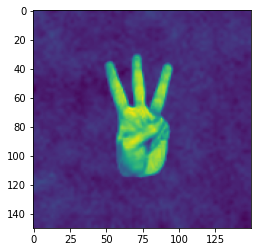

3.0


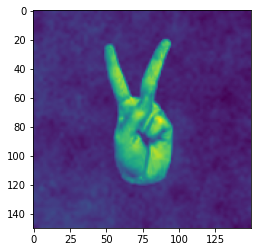

2.0


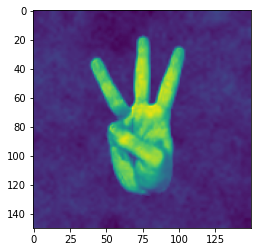

3.0


In [6]:
import matplotlib.pyplot as plt

for i in range(1,10,3):
    plt.imshow(x_train[i, :, :, 2])
    plt.show()
    print(y_train[i])

In [7]:
# y_val = to_categorical(y_val)
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_val.shape
y_val = y_val.astype('uint8')
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')
y_val.shape

(4500,)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=135)
val_generator = test_datagen.flow(x_val, y_val, batch_size=100)

# Fitting pretrained model
Using data augmentation

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary()

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.summary()

In [0]:
from keras import optimizers

conv_base.trainable = False

model.compile(loss='sparse_categorical_crossentropy', 
             optimizer=optimizers.Adam(), 
             metrics=['acc'])
model.summary()

In [27]:
x, y = val_generator[1]
print(x.shape, y.shape)

(100, 150, 150, 3) (100,)


In [0]:
history = model.fit_generator(train_generator, 
                             steps_per_epoch=100,
                             epochs=2,
                             validation_data=val_generator,
                             validation_steps=30)
# Fine-tuning not needed as the model gives good enough accuracy with data augmentation only 

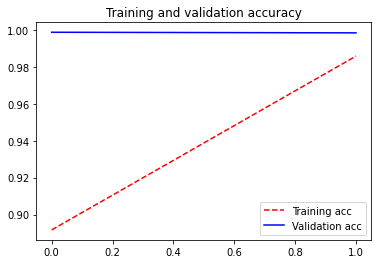

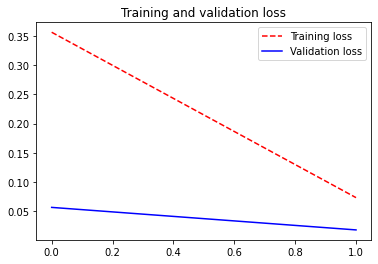

In [29]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation

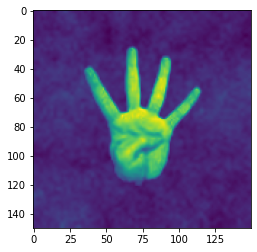

In [30]:
plt.imshow(x_test[234, :, :, 1])
plt.show()
a = 0
# for i in range(x_test.shape[0]):
#   result = model.predict(np.array([x_test[i]]))
#   if np.argmax(result) == y_test[i]:
#      a += 1 # prediction on validation data

# acc = a/(x_test.shape[0])
# acc

In [31]:
loss, acc = model.evaluate(x_test, y_test, verbose=1)

3600/3600 [==============================] - 18s 5ms/step


In [32]:
print('loss:', loss)
print('acc:', acc)

loss: 20.658756119410196
acc: 0.7172222137451172
